## ART Black Box Attack on Tesseract

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline

import numpy as np
import imageio
import visvis as vv
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os 

from art import DATA_PATH
from art.classifiers import BlackBoxClassifier
from art.defences import JpegCompression
from art.attacks import HopSkipJump
from art.attacks import ZooAttack
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy

### Make predictions

In [2]:
# read in images
image_target = imageio.imread(os.path.join(os.getcwd(), 'data/tesseract', 'dissent.png'))
image_init = imageio.imread(os.path.join(os.getcwd(), 'data/tesseract', 'assent.png'))

In [3]:
# predict function to call tesseract from the command line and convert
# its output to a one-hot encoding
def predict(x):
    
    out_label = []
    
    for x_i in x:
        # save image as intermediate png
        imageio.imsave('tmp.png', x_i)

        # run tesseract
        status = os.system("tesseract tmp.png out")
        if status != 0:
            raise Exception('Tesseract failed to run.')

        # read text
        file = open("out.txt","r+") 
        test = file.read()
        out_string = test.strip()

        # convert to categorical
        if out_string == 'dissent':
            out_label.append(0)
        elif out_string == 'assent':
            out_label.append(1)
        else: 
            out_label.append(2)
    
    return to_categorical(out_label, 3)

# init black box object
classifier = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))

In [4]:
label_dict = {0: 'dissent', 1: 'assent', 2: 'other'}

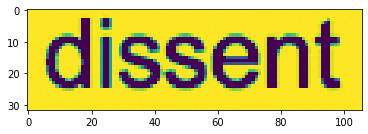

Tesseract output is: dissent


In [5]:
# this is the image we want to target
plt.imshow(image_target)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier.predict(np.array([image_target])))])

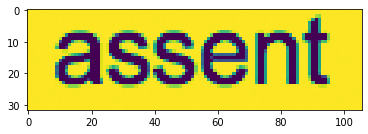

Tesseract output is: assent


In [6]:
# this is the label we want to perturb to
plt.imshow(image_init)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier.predict(np.array([image_init])))])

### Attack using HopSkipJump

Adversarial image at step 0. L2 error 7213.825 and Tesseract output assent.


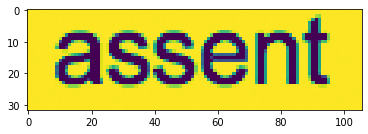

Adversarial image at step 30. L2 error 3441.4463 and Tesseract output assent.


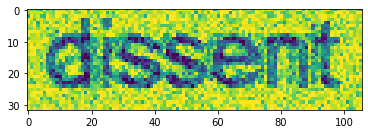

Adversarial image at step 60. L2 error 2698.7954 and Tesseract output assent.


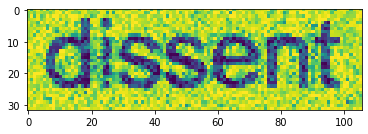

Adversarial image at step 90. L2 error 2468.0723 and Tesseract output assent.


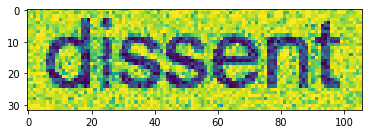

Adversarial image at step 120. L2 error 2170.0906 and Tesseract output assent.


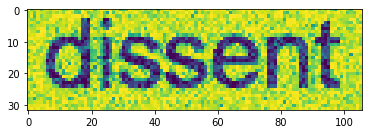

Adversarial image at step 150. L2 error 2169.1729 and Tesseract output assent.


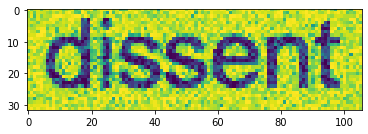

In [7]:
attack = HopSkipJump(classifier=classifier, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init])
for i in range(16):
    x_adv = attack.generate(x=np.array([image_target]), x_adv_init=x_adv, y=to_categorical([1], 3))

    #clear_output()
    if i%3 == 0:
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
              "and Tesseract output %s." % label_dict[np.argmax(classifier.predict(x_adv)[0])])
        plt.imshow(x_adv[0])
        plt.show(block=False)

    attack.max_iter = iter_step

### Defend Classifier Using Jpeg Compression

In [8]:
jpeg = JpegCompression(clip_values=(0, 255), channel_index=3)
classifier_def = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255), defences=[jpeg])

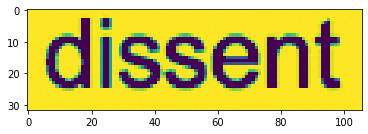

Tesseract output is: dissent


In [9]:
# this is the image we want to target
plt.imshow(image_target)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier_def.predict(np.array([image_target])))])

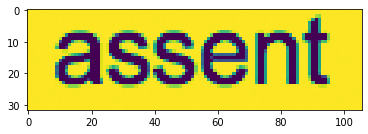

Tesseract output is: assent


In [10]:
# this is the label we want to perturb to
plt.imshow(image_init)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier_def.predict(np.array([image_init])))])

### Attack Defended Classifier Using HopSkipJump

Adversarial image at step 0. L2 error 7213.825 and Tesseract output assent.


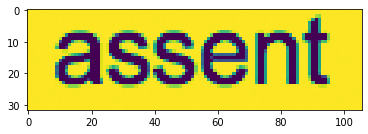

Adversarial image at step 30. L2 error 3922.6003 and Tesseract output assent.


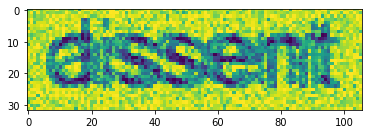

Adversarial image at step 60. L2 error 3238.8816 and Tesseract output assent.


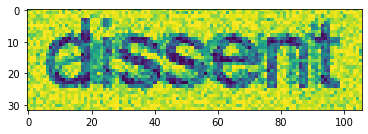

Adversarial image at step 90. L2 error 2702.5234 and Tesseract output assent.


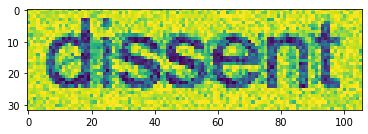

Adversarial image at step 120. L2 error 2506.4255 and Tesseract output assent.


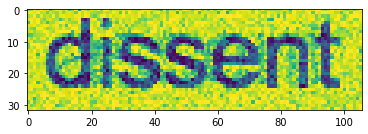

Adversarial image at step 150. L2 error 2422.4473 and Tesseract output assent.


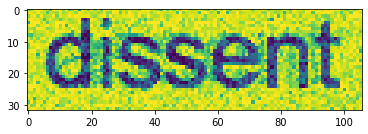

In [11]:
attack = HopSkipJump(classifier=classifier_def, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init])
for i in range(16):
    x_adv = attack.generate(x=np.array([image_target]), x_adv_init=x_adv, y=to_categorical([1], 3))

    #clear_output()
    if i%3 == 0:
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
              "and Tesseract output %s." % label_dict[np.argmax(classifier_def.predict(x_adv)[0])])
        plt.imshow(x_adv[0])
        plt.show(block=False)

    attack.max_iter = iter_step

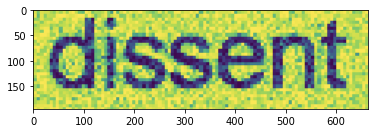

Tesseract output is: other


In [16]:
screenshot = imageio.imread(os.path.join(os.getcwd(), 'data/tesseract', 'screenshot.png'))
classifier_screenshot = BlackBoxClassifier(predict, screenshot.shape, 3, clip_values=(0, 255))
plt.imshow(screenshot)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier_screenshot.predict(np.array([screenshot])))])

In [7]:
attack = HopSkipJump(classifier=classifier, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init])

# for i in range(16):
#     x_adv = attack.generate(x=np.array([image_target]), x_adv_init=x_adv, y=to_categorical([1], 3))
#     print(image_target.shape)
#     #clear_output()
#     if i%3 == 0:
#         print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
#               np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
#               "and Tesseract output %s." % label_dict[np.argmax(classifier.predict(x_adv)[0])])
#         plt.imshow(x_adv[0])
#         plt.show(block=False)

#     attack.max_iter = iter_step

In [8]:
x_adv.shape


(1, 32, 106)